# Xây dựng mô hình hồi quy với Neural Network trong Tensorflow

Có rất nhiều định nghĩa về vấn đề hồi quy, nhưng trong trường hợp này có thể hiểu đơn giản là dự đoán một con số  của một thực thể dựa trên lượng dữ liệu thông tin nào đó giải thích hoặc mô tả về nó.

Ví dụ : 

* Dự doán giá trị của một ngôi nhà khi có thông tin về nó (như diện tích, số phòng, số lầu, nhà nằm ở thành phố hay không, nhà có nằm ở mặt tiền hay trong hẻm...)
* Dự đoán phí bảo hiểm cho một người dựa trên thông tin về giới tính, độ tuổi, tiền sử bệnh lý ... 
* Dự đoán vị trí các biên của một khung nhận diện ảnh 
* Dự đoán giá trị của một đồng tiền điện tử dựa trên dữ liệu lịch sử của nó.

## Nội dung của notebook này : 

1. Tìm hiểu kiến trúc của mô hình hồi quy
2. Tạo giả lập giá trị input và output để chuẩn bị xây dựng mô hình : 
    + `X` : biến đặc tính hay gọi là biến giải thích (inputs)
    + `y` : biến kết quả hay biến phụ thuộc (output)
3. Quan sát dữ liệu 
4. Xây dựng mô hình
    + Tạo mô hình
    + Compile mô hình
        * Định nghĩa Loss Function
        * Thiết lập optimizer
        * Tạo evaluation metrics
    + Fit mô hình
5. Đánh giá mô hình
    + Quan sát đồ thị
    + Quan sát trainning curves
    + So sánh giá trị dự đoán với giá trị thực tế
6. Lưu mô hình
7. Tải mô hình
    
##  1. Kiến trúc hồi quy với Neural Network

Mô hình hồi quy sử dụng các biến độc lập hay biến giải thích để tìm mô hình phù hợp và sau đó xuất ra giá trị dự đoán.

| **Hyperparameter** | **Giải thích** |
| --- | --- |
| Hình thái layer nhập vào (Input layer shape) | Có cùng hình thái với số lượng biến độc lập (VD (e.g. dự đoán giá nhà với 3 biến for #bedrooms, #bathrooms, #car_spaces) |
| Layer ẩn (Hidden layer) | Số lượng layer ẩn minimum = 1 , maximum = infinity | 
| Số Neurol trên layer | Thường từ 10 đến 100 |
| Hình thái layer xuất ra (Output layer shape) | Có hình thái tùy vào mong muốn (VD: xuất 1 giá trị cho giá cả nhà) | 
| Hidden activation | Thướng sử dụng [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | 
| Output activation | None, ReLu, Tanh, Logistic... |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers | 
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | 

> **Lưu ý** : **hyperparameter** trong machine learning là những tham số đã được định nghĩa bởi nhà phát triển do đó khi sử dụng phải tuân theo các quy tắc đã được định sẵn, trái lại **parameter** thường mô tả những thứ mà bản thân mô hình được học.



## 2.  Giả lập giá trị input và output để chuẩn bị xây dựng mô hình 

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

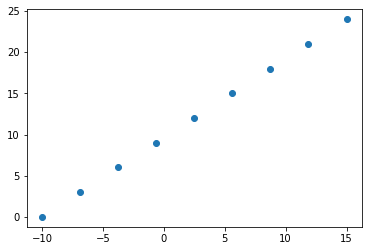

In [2]:
X = np.linspace(-10,15,9)
y = np.linspace(0,24, 9)
plt.scatter(X,y)

Trước khi xây dựng mô hình để dự đoán, bằng trực quan hoặc kiến thức toán học, bạn có thể tìm được mối liên hệ giữa `X` và `y` không ? 

Từ công thức vừa tìm, bạn thử dự đoán giá trị của `y` nếu `X = 20` là bao nhiêu ?

### Hình thái của giá trị input và output trong hồi quy 

Một trong những khái niệm quan trọng nhất khi làm việc trong Neural Network là input và output 

- `input` là những giá trị có ý nghĩa giải thích cho một đối tượng trong dữ liệu sẽ được đưa vào trong mô hình.
- `output` là giá trị dự đoán hoặc giá trị kết quả sau khi mô hình xử lý xong input

![example of input and output shapes for a housing price prediction problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/01-input-and-output-shapes-housing-prices.png)

*If you were working on building a machine learning algorithm for predicting housing prices, your inputs may be number of bedrooms, number of bathrooms and number of garages, giving you an input shape of 3 (3 different features). And since you're trying to predict the price of the house, your output shape would be 1.*

## 3. Xây dựng mô hình

Ỏ phần trên chúng ta đã có dữ liệu cũng như biết được hình thái của input và output. Bây giờ sẽ tiến hành xây dựng mô hình Neural network cho nó.

Trong Tensorflow, Có 3 bước điển hình để tạo mô hình train dữ liệu : 

- **Tạo mô hình** : Ghép các layers của Neural network lại với nhau ( sử dụng [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) hoặc import mô hình đã được xây dựng sẵn ( gọi là transfer learning)
- **Compile mô hình** : Tại đây, mô hình sẽ đo lường độ hiệu quả thông qua loss / metrics cũng như chỉ ra cách cải thiện thông qua optimizer.
- **Fit mô hình** : Mô hình sẽ cố gắng tìm mối liên hệ giữa các biến `X` để có được giá trị `y` trong dữ liệu 

Xem thêm [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) để xây dựng một mô hình cho dữ liệu hồi quy. Và sau đó chúng ta sẽ bước qua từng


In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

Thông thường khi build mô hình chúng ta sẽ sử dụng [Keras](https://keras.io/). Đây là một API được thiết kế để xây dựng mô hình deep learning dễ dàng hơn. Kể từ khi tensorflow 2.0, nó không còn rời rạc nữa mà đã được tính hợp trong `tensorflow`

In [4]:
tf.random.set_seed(42)
# Tạo mô hình sử dụng Sequential API
model_1 = Sequential()
model_1.add(Dense(1))

# Compile mô hình
model_1.compile(
    loss="mae", # mae is short for mean absolute error
    optimizer="sgd",# SGD is short for stochastic gradient descent
    metrics=["mae"]
)

model_1.fit(X,y,epochs=10,verbose=0)

In [5]:
# Mô hình đã được build hoàn tất, tiến hành dự đoán giá trị 
model_1.predict([20])

array([[16.501194]], dtype=float32)

In [6]:
X,y

(array([-10.   ,  -6.875,  -3.75 ,  -0.625,   2.5  ,   5.625,   8.75 ,
         11.875,  15.   ]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24.]))

Opps! Có vẻ như mô hình dự đoán không chính xác, với giá trị 20 ta thường kỳ vọng một con số nào đó lớn hơn `24` thậm chí có thể là `30`

## 4. Đánh giá mô hình

Đánh giá mô hình là một trong những công việc rất quan trọng, sau khi xây dựng mô hình xong, chúng ta phải xem mô hình đó hoạt động có chính xác hay đối chiếu các ý định đã đề ra trước khi xây dựng mô hình, hoặc bằng kinh nghiệm của bản thân...

Do đó, thông thường khi đánh giá mô hình ai cũng cần phải trải qua một quá trình lặp đi lặp lại nhiều lần cho đến khi cảm thấy `ổn nhất` có thể.

> B1 : Xây dựng mô hình -> B2: Đánh giá mô hình -> B3 : Cải thiện mô hình (thay đổi trên mô hình đã được xây ở B1) -> B4 : Đánh giá mô hình -> Cải thiện mô hình tiếp tục hoặc hài lòng với mô hình này -> ....

Đặc biệt, cần phải quan sát những gì mà mô hình đã xảy ra trong lúc train bằng đồ thị.



## Tạo dữ liệu lớn hơn và thực hiện các bước xây dựng và đánh giá mô hình

### Tạo dữ liệu

In [7]:
# Tạo dữ liệu lớn hơn
X = np.arange(-100, 200, 4)
y = np.arange(-90,210,4)

X[:10],y[:10]

(array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64]),
 array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54]))

In [8]:
len(X), len(y)

(75, 75)

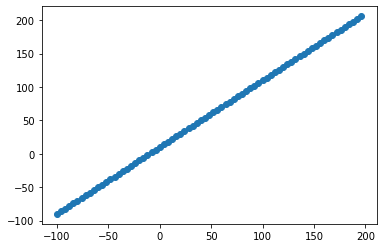

In [9]:
plt.scatter(X,y)

### Tách dữ liệu thành train và test

Một trong những bước quan trong nhất trong các dự án ML đó là tách dữ liệu thành các tập dữ liệu để `trainning` và `test` ( nếu cần thiết thì có thể chia thêm `validation`)

Mỗi tập dữ liệu đóng vai trò khác nhau : 

- Trainning : Mô hình sẽ học dựa trên dữ liệu này, thông thường nó chiếm 70% - 80% trong tổng số dữ liệu
- Validation : Khi học xong, mô hình sẽ tiến hành làm bài `test thử` để đánh giá `năng lực` đến đâu, tại đây nó sẽ thay đổi khi đoán sai. Chiếm 10% - 15% tổng số dữ liệu.
- Test : Sau khi kết thúc khóa học trainning và thi thử validation, mô hình sẽ bắt đầu thi thực sự. Lúc này, nó sẽ được đánh giá sau một quá trình học tập. Chiếm 10% - 15% tổng số dữ liệu.

In [10]:
len(X)

75

In [11]:
train_length = int(0.8 * len(X))
# Tách dữ liệu thánh trainning và test thủ công
X_train = X[:train_length]
y_train = y[:train_length]

X_test = X[train_length:]
y_test = y[train_length:]

X_train.shape, X_test.shape

((60,), (15,))

### 3. Quan sát dữ liệu 

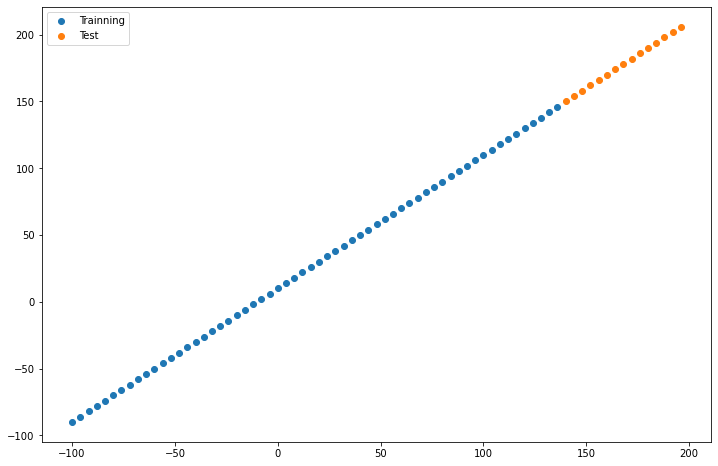

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(X_train, y_train, label="Trainning")
plt.scatter(X_test, y_test,  label="Test") 
plt.legend()

### 4. Xây dựng mô hình

In [13]:
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(1))

model.compile(
    loss="mae",
    optimizer="sgd",
    metrics=["mae"]
)

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
2/2 [==============================] - 1s 7ms/step - loss: 21.7962 - mae: 21.7962
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 22.4194 - mae: 22.4194
Epoch 3/10
2/2 [==============================] - 0s 5ms/step - loss: 19.3555 - mae: 19.3555
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 15.3823 - mae: 15.3823
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 18.2901 - mae: 18.2901
Epoch 6/10
2/2 [==============================] - 0s 9ms/step - loss: 19.8417 - mae: 19.8417
Epoch 7/10
2/2 [==============================] - 0s 14ms/step - loss: 26.9859 - mae: 26.9859
Epoch 8/10
2/2 [==============================] - 0s 8ms/step - loss: 17.3711 - mae: 17.3711
Epoch 9/10
2/2 [==============================] - 0s 8ms/step - loss: 16.5436 - mae: 16.5436
Epoch 10/10
2/2 [==============================] - 0s 12ms/step - loss: 17.0294 - mae: 17.0294


Sau khi fit mô hình, bạn có thể xem các layers và shape của mô hình bằng phương thức [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) trong nó.

> 🔑 **Note:** Quan sát một mô hình đặc biệt hữu ích khi bạn gặp sự cố không khớp hình dạng đầu vào và đầu ra.

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


`summary()` cho chúng ta thấy một số thứ sau : 

- **Model: "sequential_1"** : Tên của mô hình, thông thường nó sẽ tự đặt tên mặc định, nhưng bạn có thể đặt tên cho nó.
- **Total params** : Tổng số tham số trong mô hình.
- **Trainable parameters** :  Đây là những tham số mà mô hình có thể update khi nó train.
- **Non-trainable parameters** : Những tham số này không được update trong suốt quá trình train( điều này là trường hợp điển hình khi bạn sử dụng mô hình đã được học trước đó hay gọi là transfer learning)

> 📖 **Nguồn:** Để có cái nhìn tổng quan sâu hơn về các thông số có thể đào tạo trong một lớp, hãy xem
[MIT's introduction to deep learning video](https://youtu.be/njKP3FqW3Sk).

### Quan sát các dự đoán

In [15]:
y_preds = model.predict(X_test)

In [16]:
def plot_prediction(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds) : 
    plt.figure(figsize=(12,8))
    plt.scatter(train_data, train_labels, label="Train")
    plt.scatter(test_data, test_labels, label="Test")
    plt.scatter(test_data, predictions, label="Predict")
    plt.legend()

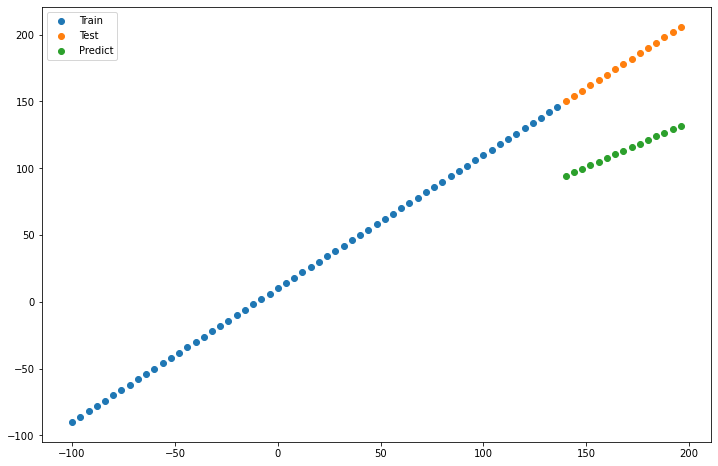

In [17]:
plot_prediction()

### Đánh giá kết quả dự đoán
Bên cạnh quan sát bằng đồ thị, công đơn vị đánh giá cũng là sự thay thế hoàn hảo cho việc đánh giá mô hình.

Tùy vào bài toán cần giải quyết sẽ có nhiều phương pháp đánh giá khác nhau

Đối với vấn đề về hồi quy thì có phương pháp đánh giá sau : 

- **Mean squared error(MSE)** : sự khác biệt trung bình bình phương giữa các dự đoán (sử dụng nếu sai số lớn hơn bất lợi hơn sai số nhỏ hơn)
- **Mean absolute error(MAE)** : sự khác biệt trung bình giữa mỗi dự đoán.
    

In [18]:
# Tạo hàm MAE, MSE

def mae(y_true, y_preds) : 
    return tf.keras.metrics.MAE(y_true, y_preds)

def mse(y_true, y_preds) : 
    return tf.keras.metrics.MSE(y_true, y_preds)



In [19]:
# Kiểm tra giá trị tensor của test label 
y_test, y_test.shape

(array([150, 154, 158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198,
        202, 206]),
 (15,))

In [20]:
# Kiểm tra giá trị tensor dự đoán
y_preds[:5], y_preds.shape

(array([[ 94.19833 ],
        [ 96.887856],
        [ 99.57738 ],
        [102.26691 ],
        [104.95643 ]], dtype=float32),
 (15, 1))

In [21]:
y_preds[:5], y_preds.shape

(array([[ 94.19833 ],
        [ 96.887856],
        [ 99.57738 ],
        [102.26691 ],
        [104.95643 ]], dtype=float32),
 (15, 1))

Ở `y_test` có dạng (10,), trong khi `y_preds` lại có dạng (10,1). Khi so sánh giá trị dự đoán với giá trị thực tế, các biến này cần có chung hình dạng, kích thước. Vì vậy, chúng ta cần đưa `y_preds` về dạng (10,).

Trong Numpy và Tensorflow có một phương thức để giảm số chiều, đó là `squeeze()`

In [22]:
y_preds = np.squeeze(y_preds)
y_preds, y_preds.shape

(array([ 94.19833 ,  96.887856,  99.57738 , 102.26691 , 104.95643 ,
        107.64595 , 110.33547 , 113.024994, 115.71452 , 118.404045,
        121.09357 , 123.7831  , 126.47262 , 129.16214 , 131.85167 ],
       dtype=float32),
 (15,))

Như vậy, `y_preds` đã có kích thước giống với `y_test`. Lúc này, ta có thể sử dụng các công cụ so sánh để đo lường độ chính xác của mô hình dự đoán.

In [23]:
mae_ = mae(y_test, y_preds)
mse_ = mse(y_test, y_preds)

mae_, mse_

(<tf.Tensor: shape=(), dtype=float32, numpy=64.975>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4253.808>)

### Cải thiện mô hình

Từ các phương pháp đánh giá mô hình hồi quy như `mae`, `mse`, tất cả đều cho giá trị rất lớn, điều đó cho thấy mô hình dự đoán không tốt. Do đó, chúng ta cần cải thiện mô hình để nó có thể dự đoán tốt hơn.

Nhớ rằng có rất nhiều cách để cải thiện mô hình, nhưng có 3 cách sử dụng rất phổ biến

1. Thêm dữ liệu : Khi có càng nhiều dữ liệu được đưa vào mô hình train, thì mô hình sẽ học được nhiều hơn -> tăng thêm khả năng dự đoán chính xác hơn.
2. Làm cho mô hình lớn hơn hoặc phức tạp hơn : Để làm được điều này, ta cần tăng số lượng hidden layer hoặc các hidden units (neurol) trong layer nhiều hơn.
3. Train mô hình lâu hơn : Thay vì ở mô hình trước chỉ cho mô hình học 10 lần, thì có thể tăng số lần học nhiều hơn bằng cách tăng epochs

Vì chúng ta đã tự tạo tập dữ liệu, nên có thể dễ dàng tạo thêm dữ liệu nhưng điều này không phải lúc nào cũng xảy ra khi làm việc với tập dữ liệu trong thế giới thực.

Vì vậy, chúng ta có thể cải thiện mô hình của mình bằng thay đổi mô hình 1 bằng cách thêm vào một số cách cải thiện mô hình như sau : 

1. `model_1` : giống như mô hình trước, với 1 layer nhưng train 100 epochs
2. `model_2` : 2 layers, 100 epochs
3. `model_3` : 3 layers, 500 epochs

In [24]:
y_train

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106, 110, 114,
       118, 122, 126, 130, 134, 138, 142, 146])

#### Build mô hình 1 

In [25]:
# model_1 
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(Dense(1))

model_1.compile(
    loss="mae",
    optimizer="sgd",
    metrics=["mae"]
)

model_1.fit(X_train,y_train, epochs=100, verbose=0)

In [26]:
model_1.evaluate(X_test, y_test)

1/1 [==============================] - 0s 291ms/step - loss: 46.9757 - mae: 46.9757


[46.975650787353516, 46.975650787353516]

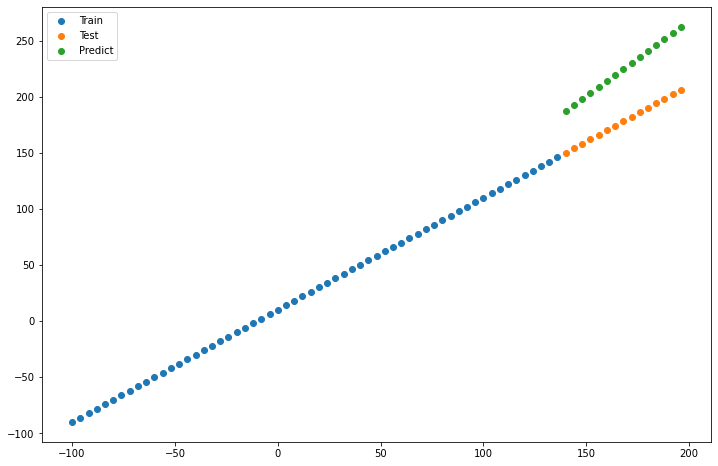

In [27]:
y_preds_1 = model_1.predict(X_test)
plot_prediction(X_train, y_train, X_test, y_test, y_preds_1)

In [28]:
y_preds_1 = np.squeeze(y_preds_1)

In [29]:
mae_1 = mae(y_test, y_preds_1)
mse_1 = mse(y_test, y_preds_1)

mae_1, mse_1

(<tf.Tensor: shape=(), dtype=float32, numpy=46.97565>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2240.2773>)

#### Build mô hình 2

In [30]:
# Set random seed
tf.random.set_seed(42)

# Replicate model_1 and add an extra layer
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1) # add a second layer
])

# Compile the model
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model
model_2.fit(X_train, y_train, epochs=100, verbose=0)

In [31]:
model_2.evaluate(X_test, y_test)

1/1 [==============================] - 0s 222ms/step - loss: 137.3578 - mae: 137.3578


[137.35784912109375, 137.35784912109375]

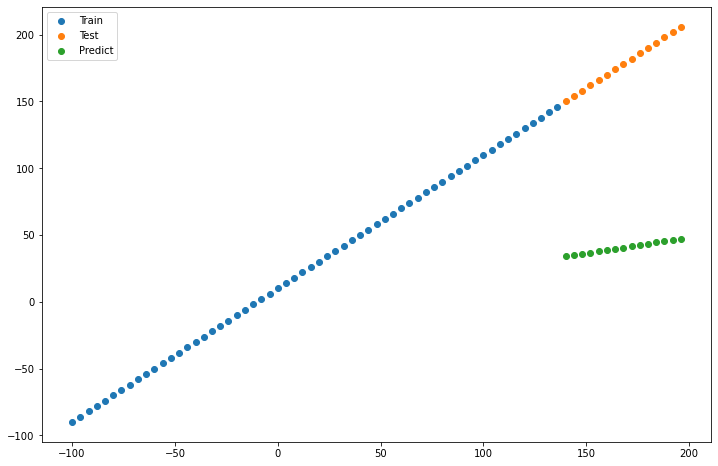

In [32]:
y_preds_2 = model_2.predict(X_test)
plot_prediction(predictions = y_preds_2)

In [33]:
y_preds_2 = np.squeeze(y_preds_2)

In [34]:
mae_2 = mae(y_test, y_preds_2)
mse_2 = mse(y_test, y_preds_2)

mae_2, mse_2

(<tf.Tensor: shape=(), dtype=float32, numpy=137.35785>,
 <tf.Tensor: shape=(), dtype=float32, numpy=19040.824>)

Có vẻ MAE của `model_2` có cải thiện hơn so với `model_1` nhưng vẫn không tốt.

#### Build mô hình 3 

In [35]:
tf.random.set_seed(42)

model_3 = Sequential()
model_3.add(Dense(1))
model_3.add(Dense(1))
model_3.add(Dense(1))

model_3.compile(
    loss="mae",
    optimizer="sgd",
    metrics=["mae"]
)

model_3.fit(X_train, y_train, epochs=500, verbose=0)

In [36]:
model_3.evaluate(X_test, y_test)

1/1 [==============================] - 0s 320ms/step - loss: 149.1841 - mae: 149.1841


[149.18411254882812, 149.18411254882812]

In [37]:
y_preds_3 = model_3.predict(X_test)
y_preds_3 = np.squeeze(y_preds_3)

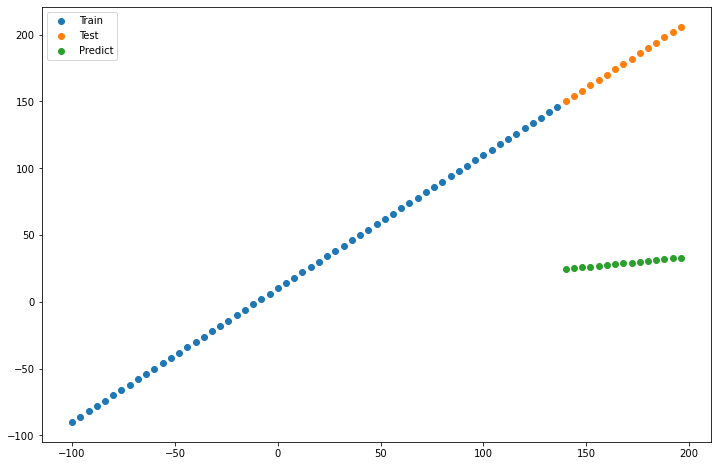

In [38]:
plot_prediction(X_train, y_train, X_test, y_test, y_preds_3)

In [39]:
mae_3 = mae(y_test, y_preds_3)
mse_3 = mse(y_test, y_preds_3)

mae_3, mse_3

(<tf.Tensor: shape=(), dtype=float32, numpy=149.18411>,
 <tf.Tensor: shape=(), dtype=float32, numpy=22470.205>)

Bây giờ, sẽ lập biểu đồ so sánh các phương pháp đo lường trong từng mô hình

In [40]:
import pandas as pd

([], [])

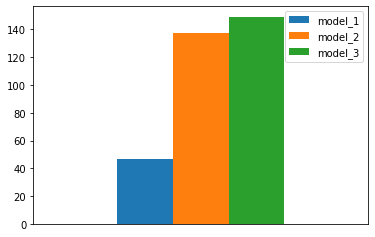

In [41]:
models_mae = {
    "model_1" : [mae_1.numpy()],
    "model_2" : [mae_2.numpy()],
    "model_3" : [mae_3.numpy()]
}

df = pd.DataFrame(models_mae)
df.plot.bar()
plt.xticks([])

Từ biểu đồ, ta có thể thấy `model_1` là tốt nhất. Tuy nhiên, nó còn có thể tốt hơn khi ta thay đổi và trải nghiệm thêm.

Một điều khác bạn cũng sẽ thấy là những gì bạn nghĩ có thể hiệu quả (chẳng hạn như train dữ liệu lâu hơn hoặc thêm số layer nhiều hơn) có thể không phải lúc nào cũng hiệu quả và điều ngược lại cũng thường xảy ra.



### Theo dõi các thử nghiệm

Một thói quen thực sự tốt cần có là theo dõi các thử nghiệm mô hình của bạn để xem thử nghiệm nào hoạt động tốt hơn những thử nghiệm khác.

> 📖 Nguồn Nhưng khi bạn xây dựng nhiều mô hình hơn, bạn sẽ muốn xem xét việc sử dụng các công cụ như:
> [Tensor board](https://tensorboard.dev/) : một phần của thư viên Tensorflow giúp theo dõi những thử nghiệm trên mô hình ( sẽ có ở những module sau)
> [Weight and Bias](https://wandb.ai/site) : một công cụ để theo dõi tất cả các loại thử nghiệm cho machine learning

## 6. Lưu mô hình

Khi train một mô hình nào đó và bạn muốn giữ mô hình đó lại để tái sử dụng cho những lần tiếp theo thay vì phải train lại từ đầu, bạn chỉ cần lưu nó lại vào nơi nào mà bạn muốn.

Save Tensorflow/Keras bằng việc sử dụng `model.save()`

Trong Tensorflow, có 2 cách để lưu mô hình : 

1. [SavedModelFormat](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format)
2. [HDF5 Format](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format)

Sự khác biệt chính giữa cả hai là SavedModel có thể tự động lưu các đối tượng tùy chỉnh (chẳng hạn như các lớp đặc biệt) mà không cần sửa đổi bổ sung khi tải lại mô hình.

Để lưu định dạng nào phù hơp nó phụ thuộc vào tình huống cần sử dụng, nhưng `SavedModelFormat` thường được sử dụng phổ biến.

Cả 2 phương thức này cùng sủ dụng phương thức `call`


In [42]:
# Save a model using the SavedModel format
model_1.save("best_model_regression")

INFO:tensorflow:Assets written to: best_model_regression/assets


In [43]:
# Kiểm tra xem thư mục hiện tại đã lưu chưa
!ls

01_neural_network_regression.ipynb  best_model_regression.h5
best_model_regression


In [44]:
# Kiểm tra xem trong best_model_regression có chưa tập tin gì
!ls best_model_regression

assets	saved_model.pb	variables


Bây giờ, thử lưu mô hình dưới định dạng `HDF5`

In [45]:
model_1.save("best_model_regression.h5")

In [46]:
!ls

01_neural_network_regression.ipynb  best_model_regression.h5
best_model_regression


## 7. Load mô hình

Ta có thể load mô hình bằng cách sử dụng `load_model()` có sẵn trong tensorflow.


In [47]:
loaded_best_model_regression = tf.keras.models.load_model("best_model_regression")
loaded_best_model_regression

Bây giờ thử xem mô hình có giống như trước khi save không nhé

In [48]:
loaded_best_model_regression.evaluate(X_test, y_test)

1/1 [==============================] - 0s 211ms/step - loss: 46.9757 - mae: 46.9757


[46.975650787353516, 46.975650787353516]

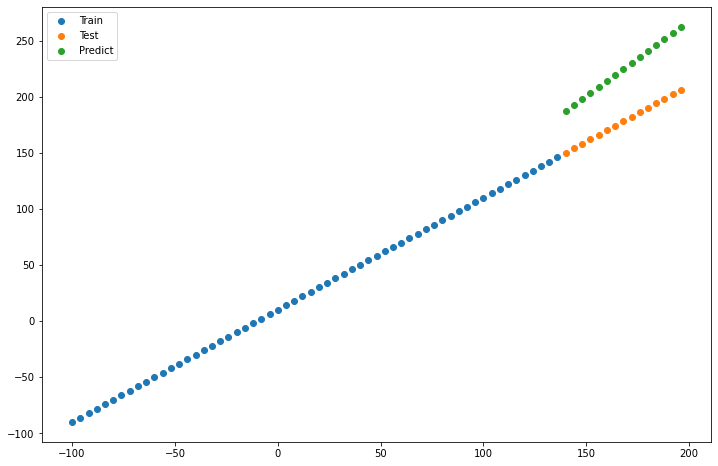

In [49]:
y_preds = loaded_best_model_regression.predict(X_test)
y_preds = np.squeeze(y_preds)
plot_prediction(predictions=y_preds)

In [50]:
mae(y_test, y_preds) == mae(y_test, y_preds_1)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

## Download mô hình với Google Colab

Giả sử bạn muốn đưa mô hình của mình từ Google Colab vào máy cục bộ, bạn có thể thực hiện một trong những việc sau:

* Click chuột vào file tìm vị trí `download` rồi tải về
* sử dụng code 

In [51]:
try : 
    from google.colab import files
    files.downdload("best_model_regression.h5")
except ModuleNotFoundError :
    print("không tìm thấy module")

không tìm thấy module


## Ví dụ với dữ liệu lớn hơn

Từ những phần trước, chúng ta đã có được nền tảng để xây dựng mô hình hồi quy với Neural network trong Tensorflow. Bây giờ, chúng ta sẽ xây dựng mô hình hồi quy với dữ liệu lớn hơn, thực tế hơn xem nó sẽ dự đoán mô hình có tốt không.

Ở bài này, chúng ta sẽ cố gắng dự báo chi phí bảo hiểm y tế của một người nào đó dựa trên thông tin của họ về độ tuổi (age), giới tính (sex), chỉ số bmi (bmi), số con (children), có hút thuốc hay không (smoking_status), nơi sinh sống (residental_region).

Để làm được điều đó, chúng tôi sẽ tận dụng bộ dữ [Medical Cost](https://www.kaggle.com/mirichoi0218/insurance) sẵn có từ Kaggle và được lưu trữ trên [Github](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv).


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [53]:
insurance_data = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [54]:
insurance_data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


Vì neural network chỉ có thể xử lý các input kiẻu `number`, nó không hiểu được các kiểu dữ liệu khác nên ta cần chuyển những cột nào không phải dạng số về kiểu `number`

Có rất nhiều cách để chuyển kiểu dữ liệu về kiểu số . Chẳng hạn như trong pandas có [`pd.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), trong sklearn có `OneHotEncoder`

Trong bài này, cần chuyển cột `sex`, `smoker`, `region` thành kiểu số

In [55]:
# Chuyển tất cả các cột thành kiểu số 
insurance_one_hot = pd.get_dummies(insurance_data)
insurance_one_hot

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,1,1,0,0,1,0,0
1334,18,31.920,0,2205.98080,1,0,1,0,1,0,0,0
1335,18,36.850,0,1629.83350,1,0,1,0,0,0,1,0
1336,21,25.800,0,2007.94500,1,0,1,0,0,0,0,1


Tách dữ liệu thành `X` và `y`

In [56]:
X = insurance_one_hot.drop("charges",axis=1)
y = insurance_one_hot["charges"]

Tách dữ liệu thành `train` và `test`. Trước đây, việc tách dữ liệu được thực hiện thủ công, việc tách dữ liệu như vậy không đem đến hiệu quả tối ưu trong quá trình train dữ liệu vì đôi khi dữ liệu được sắp xếp có thứ tự khiến cho trong qua trình train, neural network sẽ `học thuộc lòng` và khi gặp cái mới nó sẽ trở nên khó nhận biết. Do đó, cần phải xáo trộn dữ liệu để nó sẽ không `học tủ` được.

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8, 
    shuffle=True, # shuffle = True để dữ liệu được xáo trộn không theo thứ tự
    random_state=42)

Tiến hành build mô hình

In [59]:
tf.random.set_seed(42)

insurance_model_1 = Sequential()
insurance_model_1.add(Dense(1))
insurance_model_1.add(Dense(1))

insurance_model_1.compile(
    loss="mae",
    optimizer="sgd",
    metrics=["mae"]
)

insurance_model_1.fit(X_train, y_train, epochs=100, verbose=0)

In [60]:
insurance_model_1.evaluate(X_test, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 8628.2402 - mae: 8628.2402


[8628.240234375, 8628.240234375]

mae của mô hình quá lớn, ta cần cải thiện mô hình này.

* Tăng số layer lên 3
* Tăng số units trong mỗi layers 
* Thay đôi optimizer từ SGD -> Adam

In [61]:
tf.random.set_seed(42)

insurance_model_2 = Sequential()
insurance_model_2.add(Dense(10))
insurance_model_2.add(Dense(10))
insurance_model_2.add(Dense(1))

insurance_model_2.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae"]
)

history_2 = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

In [62]:
insurance_model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 8ms/step - loss: 6417.2144 - mae: 6417.2144


[6417.21435546875, 6417.21435546875]

`model_2` có vẻ tốt hơn nhiều, Việc sử dụng mô hình lơn hơn với Adam optimizer cải thiện đáng kể cho mô hình

> **🔑Lưu ý:** Đối với nhiều vấn đề, [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) là sự lựa chọn tuyệt vời.

Text(0, 0.5, 'loss')

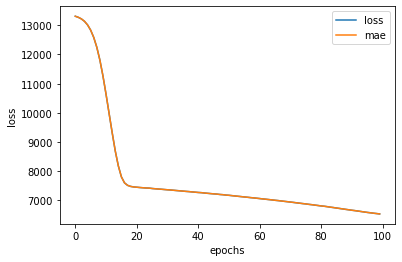

In [63]:
pd.DataFrame(history_2.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")

Từ biểu đồ, có vẻ MAE vẫn đang giảm. Như vậy, nếu train thêm lâu hơn nữa thì khả năng nó vẫn còn giảm.

> Câu hỏi là chúng ta nên train mô hình này bao lâu ?
> Nó phụ thuộc vào vấn đề đang giải quyết. Đôi khi qúa trình train đòi hỏi rất nhiều thời gian, nhưng có những quá trình không như vậy. Một phương pháp sử dụng rất phổ biến đó là thiết lập mô hình train rất lâu (chẳng hạn như 1000 epochs) nhưng thiết lập [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) để tự động ngưng lại khi nó thấy mô hình không thể cải thiện thêm được nữa, tức là học như vậy là đủ rồi.

In [64]:
# Cố gắng train thêm 100 epochs
history_2 = insurance_model_2.fit(X_train, y_train, epochs=100,verbose=0)

In [65]:
insurance_model_2_loss, insurance_model_2_mae = insurance_model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 5ms/step - loss: 5570.6719 - mae: 5570.6719


<AxesSubplot:>

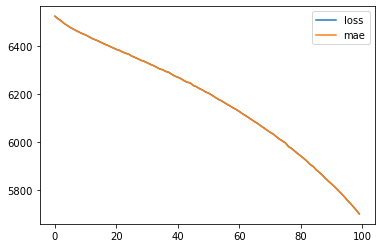

In [66]:
pd.DataFrame(history_2.history).plot()

Có thể thấy nó tiếp tục giảm khoảng 10% khi tăng số lượng epochs thêm 100

## Preprocessing data (normalization and standardization)

Khi làm việc với neural network, không phải lúc nào các đặc tính của một đối tượng đều có cùng đơn vị đo lường giống nhau,(ví du huyết áp của bệnh nhân khác với chỉ số máu xét nghiệm) chính vì vậy nếu giá trị của thuộc tính này rất lớn, trong khi giá trị thuộc tính kia rất nhỏ nhưng thuộc tính nhỏ lại có ý nghĩa tương đương hoặc quan trọng hơn thuộc tính lớn thì cũng không thể thể hiện được ý nghĩa quyết định đến kết quả vì bị lấn át bởi giá trị lớn. Chính vì lẽ đó, ta cần chuyển tất cả các thuộc tính về phạm vi 0-1 để tất cả các đều thể hiện được đúng ý nghĩa của nó. Và phép biến đổi này được gọi là **chuẩn hóa normalization**. 

Cũng có một phương pháp biến đổi khác được gọi là **chuẩn hóa standardization** để chuyển đặc tính thành các phương sai (variance) và giá trung bình (mean) 0 

Khi thực hiện chuyển đổi dữ liệu từ các phương pháp trên, ta gọi đó là **preprocessing pipeline** (một loạt các hàm được thực hiện để chuẩn bị cho dữ liêụ có thể sử dụng trong neural network)

Một số bước chính bạn sẽ thực hiện để xử lý trước dữ liệu của mình cho Neural Network bao gồm : 

* Chuyển tất cả dữ liệu thành kiểu `number` ( Neural network không xử lý dữ liệu kiểu khác ngoài `number`)
* Chắc chắn rằng dữ liệu phải có cùng shape (giữa input shape và output shape)
* [Scale các đặc tính của đối tượng (Feature scaling)] : 
    - Chuẩn hóa dữ liệu Normolization ( Làm cho các đặc tính này dao động từ 0 - 1). Điều này được thực hiện bằng cách trừ giá trị nhỏ nhất, sau đó chia cho giá trị lớn nhất của đặc tính đó. Còn có cách gọi khác là `min-max scaling`.
    - Chuẩn hóa dữ liệu Standardization (trung bình mean là 0, phương sai variance là 1). Điều này được thực hiện bằng cách trừ cho giá trị trung bình sau đó chia cho độ lệch chuẩn)
    - Nên sử dụng chuẩn hóa nào ?
        + Với Neural network thường sử dụng Normolization hơn với giá trị dao động tự 0 đến 1 ( đặc biệt khi xử lý ảnh).
        
> **Resource:** Để tìm hiểu thêm về Feature Scaling, xem những nguồn dưới đây:

* [Scikit-Learn's documentation on preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data).
* [Scale, Standardize or Normalize with Scikit-Learn by Jeff Hale](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).
    

    

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [104]:
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [105]:
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Trước khi chuyển các cột không phải kiểu `number` thành `number`, chúng ta sẽ chuẩn hóa những cột nào có kiểu `number` trước.

Để làm được việc này, chúng ta sẽ sử dụng vài class trong sklearn như sau: 

* `make_columns_transform` : xây dựng hàm tiền xử lý dữ liệu nhiều bước cho các trnasformations sau : 
    * `MinMaxScaler` : Chuẩn hóa dữ liệu có kiểu `number`
    * `OneHotEncoder` : Đưa các cột về kiểu `number`
    
   

In [106]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [107]:
X = insurance.drop("charges", axis=1)
y = insurance["charges"]


In [108]:
ct = make_column_transformer(
    (MinMaxScaler(),["age", "bmi", "children"]), 
    (OneHotEncoder(handle_unknown="ignore"),["sex", "smoker", "region"])
)


X = ct.fit_transform(X)

Tách dữ liệu thành `train` và `test`

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((1070, 11), (268, 11), (1070,), (268,))

Dữ liệu đã được chuẩn hóa và chuyển tất cả thành kiểu `number`, bắt đầu tạo mô hình.

In [119]:
tf.random.set_seed(42)

insurance_model_3 = Sequential()
insurance_model_3.add(Dense(100))
insurance_model_3.add(Dense(10))
insurance_model_3.add(Dense(10))
insurance_model_3.add(Dense(1))

insurance_model_3.compile(
    loss="mae",
    optimizer="adam",
    metrics=["mae"]
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-3 * 10 ** (epoch / 20))

history_3 = insurance_model_3.fit(X_train, y_train, epochs=200, verbose=0)

đánh giá mô hình trên với dữ liệu được chuẩn hóa.

In [120]:
insurance_model_3_loss, insurance_model_3_mae = insurance_model_3.evaluate(X_test, y_test)
insurance_model_3_loss, insurance_model_3_mae

9/9 [==============================] - 0s 3ms/step - loss: 3673.3059 - mae: 3673.3059


(3673.305908203125, 3673.305908203125)

<AxesSubplot:>

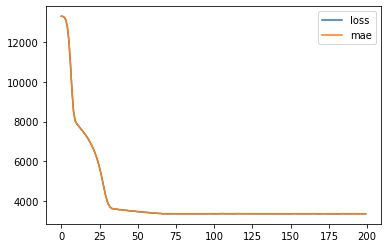

In [122]:
pd.DataFrame(history_3.history).plot()

chúng ta có thể thấy việc chuẩn hóa dữ liệu dẫn đến ít lỗi hơn 10% khi sử dụng cùng một mô hình so với việc không chuẩn hóa dữ liệu

Đây là một trong những lợi ích của chuẩn hóa. Ngoài ra, kết quả có thể thay đổi nếu chúng ta thay đổi kiến trúc của các mô hình, ví dụ: thêm nhiều hidden layer hoặc trên mỗi layer thêm nhiều units.